<p style="padding: 10px; border: 1px solid black;">
<img src="../mlu_utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>


# <a name="0">Machine Learning University</a>
## <a name="0">Lab4a: Self-consistency</a>

This notebook introduces the Self-consistency prompting strategy, a technique that is similar to chain-of-thought prompting. However, instead of taking the obvious step-by-step, or greedy decoding, self-consistency prompts the model to sample a variety of reasoning paths. Then, the model aggregates the final answer based on multiple data points from the various paths. 
    
Self-consistency leverages the intuition that a complex reasoning problem typically admits multiple different ways of thinking leading to its unique correct answer. According to the original paper, self-consistency improves Chain-of-thought prompting when used in a range of common arithmetic and common-sense reasoning benchmarks. 
    
1. <a href="#1">Import libraries</a>
2. <a href="#2">Set up Bedrock for inference</a>
3. <a href="#3">Self-consistency</a>
    - <a href="#31">Decoding strategies for text generation</a>
    - <a href="#32">Arithmetic reasoning with zero-shot prompting</a>
    - <a href="#33">Arithmetic reasoning with chain-of-thought prompting</a>
    - <a href="#34">Arithmetic reasoning with self-consistency</a>
4. <a href="#4">Evaluation of results</a>
5. <a href="#5">Quizzes</a>    
    
Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

---

<br/>
You will be presented with coding activities to check your knowledge and understanding throughout the notebook whenever you see the MLU robot:
    
</p>

<img style="display: block; margin-left: auto; margin-right: auto;" src="../mlu_utils/activity.png" alt="Activity" width="125"/>

### <a name="1">1. Import libraries</a>
(<a href="#0">Go to top</a>)

Let's start by installing all required packages as specified in the `requirements.txt` file and importing several libraries.

In [ ]:
%%capture
!pip install -q -r ../requirements.txt

In [ ]:
import sys
sys.path.append('..')

import boto3
import re
import random
import numpy as np
from collections import Counter

from langchain.llms.bedrock import Bedrock
from langchain.prompts import PromptTemplate

from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2
from mlu_utils.utils import *


### <a name="2">2. Set up Bedrock for inference</a>
(<a href="#0">Go to top</a>)

To get started, set up Bedrock and instantiate an active `bedrock-runtime` to query LLMs. 

Let us define a custom function to run inference with Bedrock-hosted models. The code below leverages [LangChain's Bedrock integration](https://python.langchain.com/docs/integrations/chat/bedrock/) and allows to use Bedrock-hosted models.


Next, use Bedrock for inference to test everything works as expected. 

**In this notebook we will use [Amazon Titan Text G1 - Lite](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-text-models.html)**, a model that offers a good balance of quality, speed, and cost. The model offers enhanced text generation capabilities, making it well-suited to language tasks with a greater degree of complexity.

In [ ]:
# Example model prompting Titan
MODEL = "amazon.titan-text-lite-v1"
TEMP = 0.0

Markdown(generate_outputs("Hi, how are you?", MODEL, TEMP, max_tokens=128)[0])

In [ ]:
# Example model prompting Mistral

MODEL = "mistral.mistral-7b-instruct-v0:2"
TEMP = 0.0

Markdown(generate_outputs("<s>[INST]Hi, how are you?[/INST]", MODEL, TEMP, max_tokens=128)[0])

### <a name="3">3. Self-consistency</a>
(<a href="#0">Go to top</a>)

Self-consistency was proposed in [Self-Consistency Improves Chain of Thought Reasoning in Language Models](https://arxiv.org/abs/2203.11171), by Wang et al. (2022). The paper introduces a new decoding strategy to replace the naive greedy decoding used in chain-of-thought prompting. The idea is to generate multiple, diverse reasoning paths through few-shot CoT, and use those completions to verify the consistency of the model's responses. This helps boost the performance of CoT prompting on tasks involving arithmetic and commonsense reasoning.

Below you will see an example of a Bedrock-hosted LLM improving its performance in an arithmetic task by using the self-consistency prompting technique.

<div>
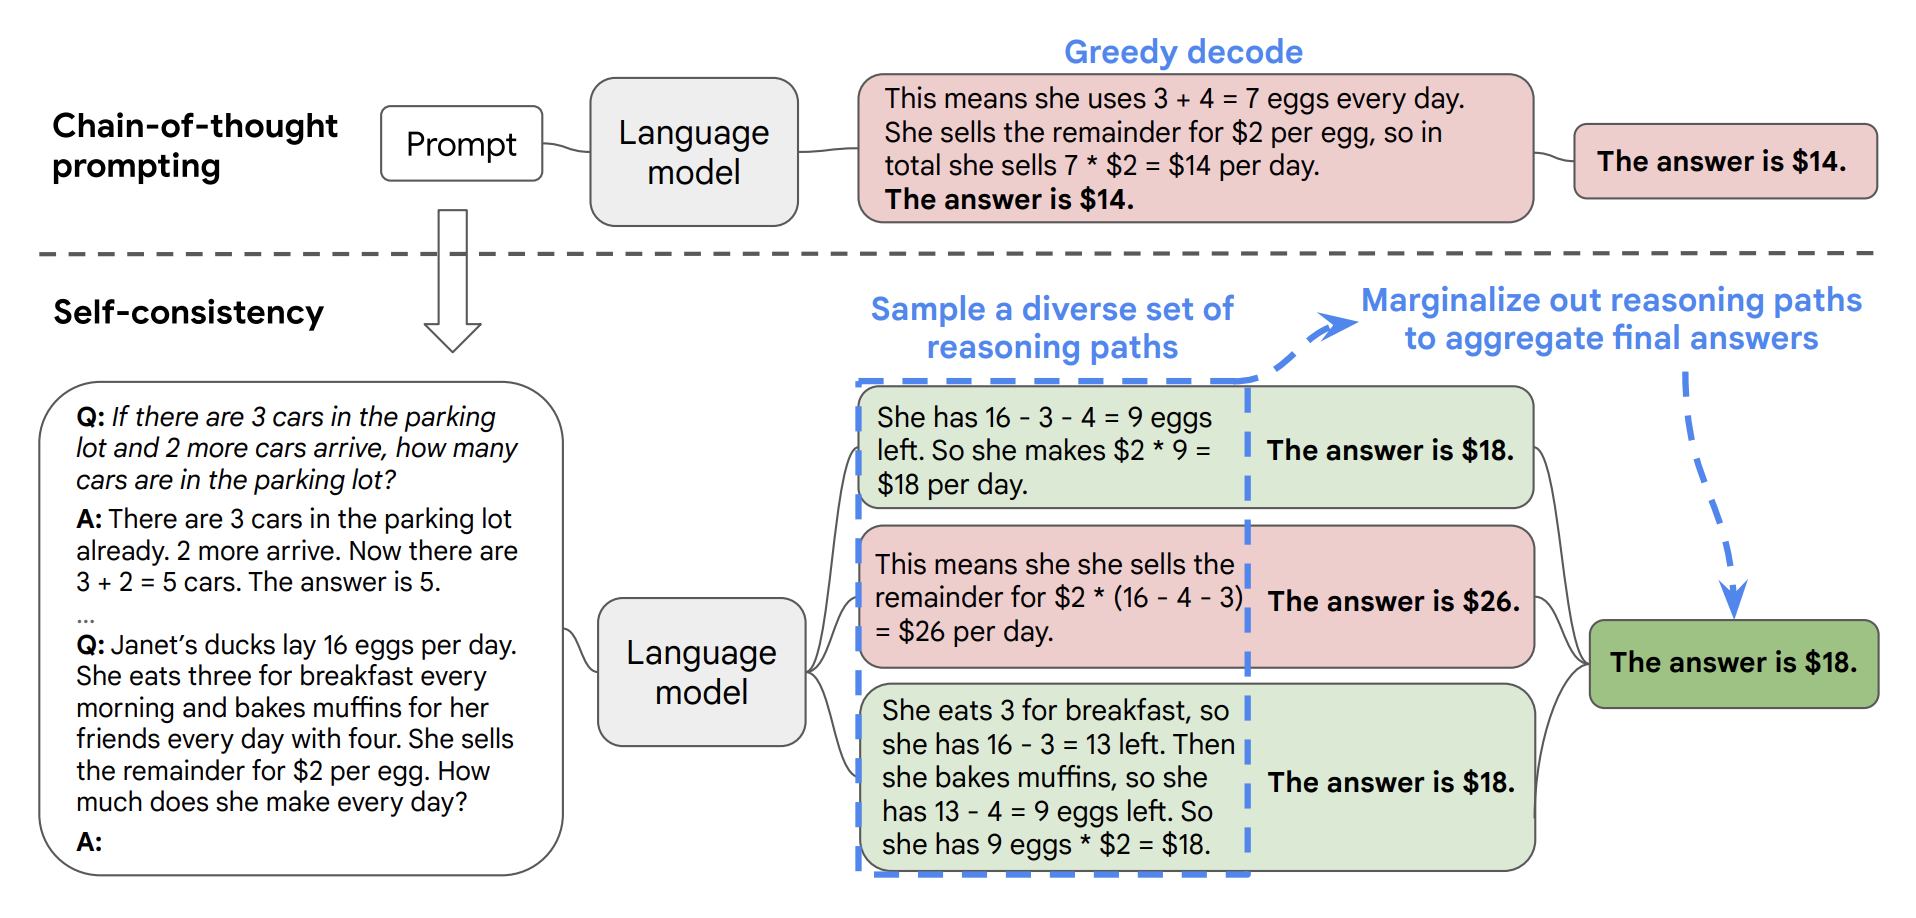
</div>


#### <a name="31">3.1. Decoding strategies for text generation</a>
(<a href="#0">Go to top</a>)

Decoder-only generative models, like Jurassic or Claude, generate text one token at a time, which is predicted based on the previous context. At each step, the model outputs a probability distribution, representing the likelihood of each token appearing next, given the prompt so far. **Decoding** is the process of turning the probability distributions generated by the model into actual text. 

**Greedy decoding** is a deterministic decoding method that selects the token with the highest probability at each step. It is "greedy" in always choosing the individually most likely token. While simple and fast, this greediness involves the risk of getting stuck in repetitive loops, as the wider probability space is ignored. Greedy decoding can produce less creative results than sampling-based stochastic decoding methods that better capture the diversity of possible outputs.

When the temperature is set to 0 in decoder-only models, the model will always choose the word with the highest probability. Effectively, this process is equivalent to greedy decoding. This determinism means that when the same prompt is input to the model multiple times, the output generated will be always identical.

**Sampling** introduces stochasticity into the decoding process by randomly selecting each next word based on the probability distribution predicted by the model, rather than always picking the single most likely next token. This injects randomness: the sampled word is not guaranteed to have the highest individual probability. Sampling allows for greater diversity in the generated text and avoids the deterministic decoding's tendency to get stuck in repetitive loops. It enables the model to better explore the full distribution of potential outputs at each time step. Sampling chooses tokens randomly in a way that better matches the model's probabilistic predictions. The stochasticity introduced by sampling increases the model's capacity to generate varied, creative output, showcasing a breadth of possibilities.

Read more about decoding strategies in this article: [Decoding Methods and Stochasticity for Amazon Titan, Bedrock, and Beyond](https://guide.aws.dev/articles/AR8QAM13RgTUmFF5wUSKRf8Q/decoding-methods-and-stochasticity-for-amazon-titan-bedrock-and-beyond).

See an example of **greedy decoding** below:

In [ ]:
prompt = """Wisdom is easily acquired when"""

MODEL = "amazon.titan-text-lite-v1"
TEMP = 0.0

for output in generate_outputs(prompt, MODEL, TEMP, max_tokens=128, n=5):
    display(Markdown(" ".join([prompt, output])))
    display(Markdown("---"))

See an example of **stochastic sampling for decoding** below, controlled by the temperature.

In [ ]:
prompt = """Wisdom is easily acquired when"""

MODEL = "amazon.titan-text-lite-v1"
TEMP = 0.75

for output in generate_outputs(prompt, MODEL, TEMP, max_tokens=128, n=5):
    display(Markdown(" ".join([prompt, output])))
    display(Markdown("---"))

#### <a name="32">3.2. Arithmetic reasoning with zero-shot prompting</a>
(<a href="#0">Go to top</a>)

In this lab we use an **arithmetic reasoning task** from [GSM8K](https://paperswithcode.com/dataset/gsm8k), a dataset of 8.5K high quality grade school math problems created by human problem writers. This is a reasoning task with a fixed answer, in this case 25 km. The fact that this type of questions have a unique correct answer is why researchers have generally considered greedy decoding to approach them. However, as shown below, **Titan text-lite is not able to solve the task correctly with greedy generation**.

In [ ]:
question = """
Question: Robert made two stops during his 80-km car trip. He first stopped after 40 km. His second stop was 15 km before the end of the trip. How many km did he travel between his first and second stops?

Answer:
"""

MODEL =  "amazon.titan-text-lite-v1"
TEMP = 0.0

display(Markdown(question))
display(Markdown("---"))
#display(Markdown(generate_outputs(question, MODEL, TEMP, max_tokens=512, stop_sequences=["Answer:"])[0]))
display(Markdown(generate_outputs(question, MODEL, TEMP, max_tokens=512)[0]))

<div style="border: 4px solid coral; text-align: center; margin: auto; padding-left: 50px; padding-right: 50px">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Try asking the same question to other models, such as <b><a href="https://aws.amazon.com/bedrock/mistral/">Mistral</b></a> and check whether they are able to produce the correct answer in the zero-shot scenario with greedy decoding.</p>
    <br>
</div>

In [ ]:
############## CODE HERE ####################



############## END OF CODE ##################

#### <a name="33">3.3. Arithmetic reasoning with chain-of-thought prompting</a>
(<a href="#0">Go to top</a>)

As shown in [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/abs/2201.11903) by Wei et al. (2022), chain of thought (i.e. asking the system to generate a series of intermediate reasoning steps) can significantly improve the ability of LLMs to perform complex reasoning. 

The following pairs of questions and answers can be used as few-shot examples to elicit a full chain of thought prompt for math word problems. This same few-shot prompt is used in both the Chain-of-thought and in the Self-consistency papers to evaluate performance of LLMs in arithmetic reasoning tasks. The prompt contains a series of math questions and answers, where the answer reasons about the arithmetic needed to arrive at the correct answer. 

In [ ]:
few_shot_arithmetic_examples = """
Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?

Answer: There are 15 trees originally. Then there were 21 trees after some more were planted. So there must have been 21 - 15 = 6. The answer is 6.

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?

Answer: There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5. The answer is 5.

Question: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?

Answer: Originally, Leah had 32 chocolates. Her sister had 42. So in total they had 32 + 42 = 74. After eating 35, they had 74 - 35 = 39. The answer is 39.

Question: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?

Answer: Jason started with 20 lollipops. Then he had 12 after giving some to Denny. So he gave Denny 20 - 12 = 8. The answer is 8.

Question: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?

Answer: Shawn started with 5 toys. If he got 2 toys each from his mom and dad, then that is 4 more toys. 5 + 4 = 9. The answer is 9.

Question: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?

Answer: There were originally 9 computers. For each of 4 days, 5 more computers were added. So 5 * 4 = 20 computers were added. 9 + 20 is 29. The answer is 29.

Question: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?

Answer: Michael started with 58 golf balls. After losing 23 on tuesday, he had 58 - 23 = 35. After losing 2 more, he had 35 - 2 = 33 golf balls. The answer is 33.

Question: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?

Answer: Olivia had 23 dollars. 5 bagels for 3 dollars each will be 5 x 3 = 15 dollars. So she has 23 - 15 dollars left. 23 - 15 is 8. The answer is 8.

"""

We assemble the math few-shot examples above with the concrete arithmetic task that we want the model to solve. We prompt **Titan-text-lite** with it and use **greedy decoding** to generate the most deterministic response. We observe that in this case, despite prompting with chain-of-thought, the **model fails** at reasoning correctly to arrive at the right answer.

In [ ]:
cot_template = """
{few_shot_examples}

{question}
"""

prompt = PromptTemplate.from_template(cot_template).format(
    few_shot_examples=few_shot_arithmetic_examples, 
    question=question
)

display(Markdown(prompt))
display(Markdown("---"))

MODEL = "amazon.titan-text-lite-v1"
TEMP = 0.0

Markdown(generate_outputs(prompt, MODEL, TEMP, max_tokens=512)[0])

#### <a name="34">3.4. Arithmetic reasoning with self-consistency</a>
(<a href="#0">Go to top</a>)

Next we try the self-consistency method. Since LLMs are not perfect reasoners, they might produce an incorrect reasoning path or make a mistake in one of the reasoning steps, as seen in the CoT example above. However, it is hypothesized that diverse reasoning processes are likely to produce correct responses in a majority of the cases. Even when the desired answer is fixed, introducing diversity in the reasoning processes can be highly beneficial; therefore we leverage sampling, as commonly used for open-ended text generation, to achieve this goal. 

Self-consistency prompting follows a **“sample-and-marginalize” decoding** procedure: 
- first sample from the LLM's decoder to generate a diverse set of outputs
- each reasoning path might lead to a different final answer
- the optimal answer is determined by finding the most consistent one in the response set.

To sample diverse reasoning paths, we follow similar settings to those suggested in the Self-consistency paper, i.e. we apply temperature sampling, for instance `T=0.5`.

Let's produce a set of answers to the prompt using temperature sampling. We can see that some of the responses are correct, and a majority seems to be emerging. **Note that the generated outputs vary each time. It might be that you don't see a majority of correct answers when sampling 5 responses.**

In [ ]:
T_SAMPLE = 0.6

completions = generate_outputs(prompt, MODEL, T_SAMPLE, max_tokens=128, n=10)

for completion in completions:
    display(Markdown(completion))
    display(Markdown("---"))

### <a name="4">4. Evaluation of results</a>
(<a href="#0">Go to top</a>)

To fully evaluate the performance of self-consistency, we create a helper function to extract the numerical answer from the LLM output. We implement a simple regex search, first looking for instances of `Answer` followed by a number. In the absence of a match, we observe that the relevant answer tends to be the last number that is produced in the response string. This captures the majority of the observed cases.

In [ ]:
def extract_answer(text:str) -> int:
    """
    Parser to extract the numerical answer to the math task
    """
    answer = None
    # Pattern to find "Answer *** Number"
    pattern1 = r".*[aA]nswer.*?(\d+)"
    # Pattern to find the last number in a string
    # https://stackoverflow.com/questions/5320525/regular-expression-to-match-last-number-in-a-string
    pattern2 = r"(\d+)(?=\D*$)"
    # Try with first pattern
    match = re.findall(pattern1, text, re.DOTALL)
    if match:
        answer = int(match[0])
    else:
        # Try with second pattern
        match = re.findall(pattern2, text, re.DOTALL)
        if match:
            answer = int(match[0])
    return answer

Let's check that the parser function correctly extracts the numerical answer from the responses generated above.

In [ ]:
[extract_answer(c) for c in completions]

We check the performance of the self-consistency method by running 3 rounds of text generation, each with 20 generated outputs. We then extract the majority vote as the correct answer. To ensure robustness of results, we sample at 3 different temperatures. 

In [ ]:
MODEL = "amazon.titan-text-premier-v1:0"
T_SAMPLE = [0.5, 0.6, 0.7]

completions = {}
answers = {}

for gen_round in range(3):
    completions[gen_round] = generate_outputs(
        prompt, 
        MODEL, T_SAMPLE[gen_round], 
        max_tokens=128, 
        # stop_sequences=["Question:"], 
        n=10
    )
    answers[gen_round] = [extract_answer(c) for c in completions[gen_round]]
    counts = Counter(answers[gen_round])
    majority_answer = counts.most_common(1)[0][0]
    print(f"Temperature: {T_SAMPLE[gen_round]}")
    print(f"Majority answer: {majority_answer}")
    print("")

### Conclusion

The self-consistency method may or may not be able to obtain the correct answer (25 km) in all three rounds depending on the model of choice. Please notice that depending on the particular scenario, CoT prompting, and models used, results and performance of this approach might vary.

<div style="border: 4px solid coral; text-align: center; margin: auto; padding-left: 50px; padding-right: 50px">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;"><b>Well done on completing the lab. Now it's time for you to get creative.</b></p>
    <p style=" text-align: center; margin: auto;">Try running the method to solve other arithmetic reasoning tasks as can be found in the <a href="https://github.com/openai/grade-school-math/tree/master">GSM8K dataset</a>.</p>
    <br>
</div>


In [ ]:
############## CODE HERE ####################



############## END OF CODE ##################

---
### <a name="5">Quiz Questions</a>

Well done on completing the lab! Now, it's time for a brief knowledge assessment.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Answer the following questions to test your understanding.</p>
    <br>
</div>

In [ ]:
from mlu_utils.quiz_questions import *

lab4a_question1

# Thank you!

<p style="padding: 10px; border: 1px solid black;">
<img src="../mlu_utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>